In [ ]:
!pip install seaborn
!pip install tensorflow
!pip install imblearn
!pip install optuna

In [ ]:
!pip3 install ipywidgets

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold

from imblearn.over_sampling import RandomOverSampler, SMOTE

import optuna
from optuna.trial import Trial

import random

In [2]:
# Path to your .pkl file
file_path = 'D:/Waffer Data/WM811K.pkl'

# Load the dataset
df = pd.read_pickle(file_path)

# Function to find dimensions
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1

# Apply the function to the waferMap column
df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(5)


,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,waferMapDim
530577,515.0,"[0, 0]",lot33214,"[0, 0]",18.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...","(25, 27)"
165412,533.0,"[0, 0]",lot10581,"[0, 0]",12.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...","(26, 26)"
570594,710.0,"[0, 0]",lot35737,"[0, 0]",4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","(32, 29)"
748795,518.0,none,lot44996,Training,12.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...","(27, 25)"
533170,710.0,"[0, 0]",lot33340,"[0, 0]",20.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...","(32, 29)"


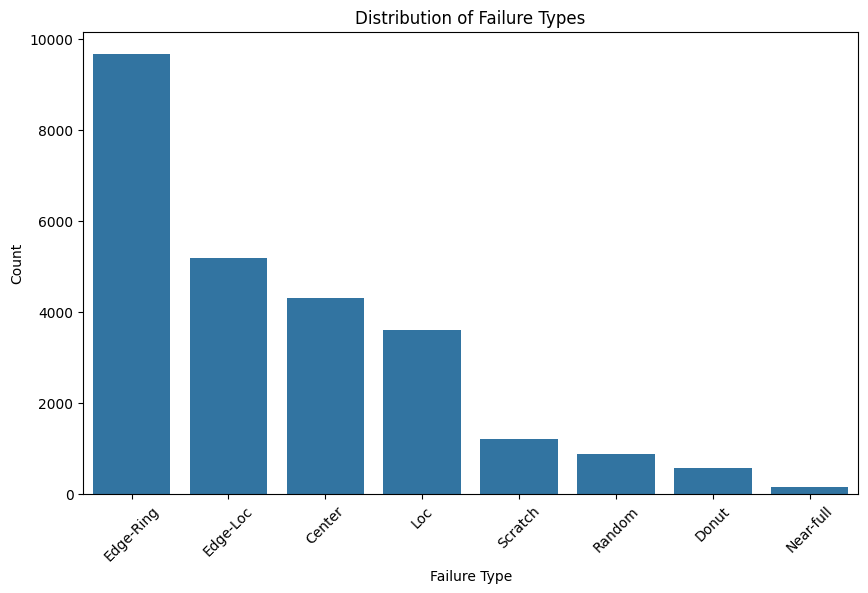

In [3]:
# Function to check if the list is [0, 0] and return 'Unknown'
def replace_zero_zero(x):
    # Check if the element is exactly [0, 0]
    if isinstance(x, (list, np.ndarray)) and np.array_equal(x, [0, 0]):
        return 'Unknown'
    return x

# Create a new DataFrame df_modified to keep the original df intact
df_modified = df.copy()

# Apply the function to both 'failureType' and 'trainTestLabel' columns
df_modified['failureType'] = df_modified['failureType'].apply(replace_zero_zero)
df_modified['trainTestLabel'] = df_modified['trainTestLabel'].apply(replace_zero_zero)

# Remove entries with 'No pattern' or 'Unknown'
df_modified_labelled = df_modified[~df_modified['failureType'].isin(['none', 'Unknown'])].reset_index(drop=True)

# Count the occurrences of each failure type
label_counts = df_modified_labelled['failureType'].value_counts()

# Plotting the label distribution
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


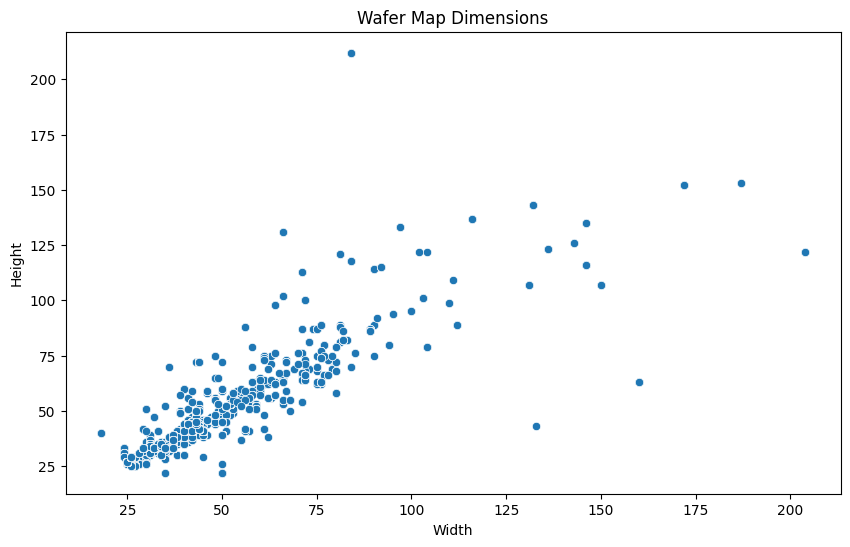

In [4]:
# Extract dimensions
dimensions = df_modified_labelled['waferMap'].apply(lambda x: x.shape)

# Create a DataFrame of dimensions
dim_df = pd.DataFrame(dimensions.tolist(), columns=['Height', 'Width'])

# Plotting the distribution of dimensions
plt.figure(figsize=(10,6))
sns.scatterplot(x='Width', y='Height', data=dim_df)
plt.title('Wafer Map Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


In [5]:
from PIL import Image

# Define the target dimension
target_dim = (64, 64)

def resize_wafer_map(wmap):
    # Convert numpy array to PIL Image
    img = Image.fromarray(wmap.astype('uint8'))
    # Resize the image
    img_resized = img.resize(target_dim, Image.Resampling.LANCZOS)
    # Convert back to numpy array
    return np.array(img_resized)


In [6]:
# Apply resizing to wafer maps
df_modified_labelled['waferMap_resized'] = df_modified_labelled['waferMap'].apply(resize_wafer_map)

In [7]:
# Flatten the wafer maps
df_modified_labelled['waferMap_flat'] = df_modified_labelled['waferMap_resized'].apply(lambda x: x.flatten())

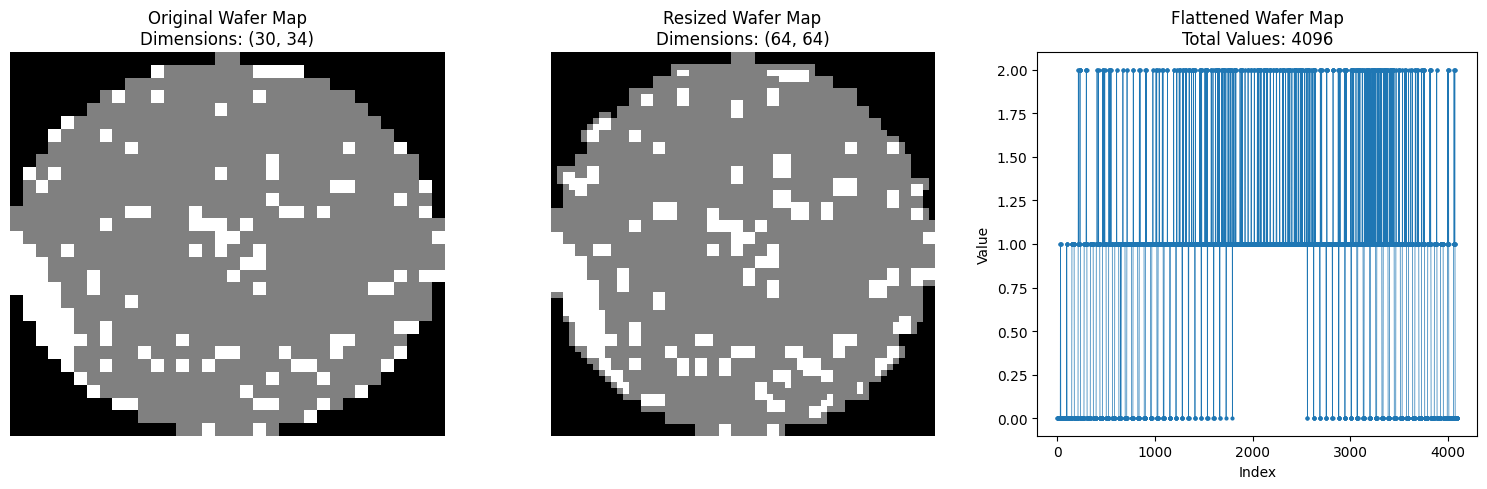

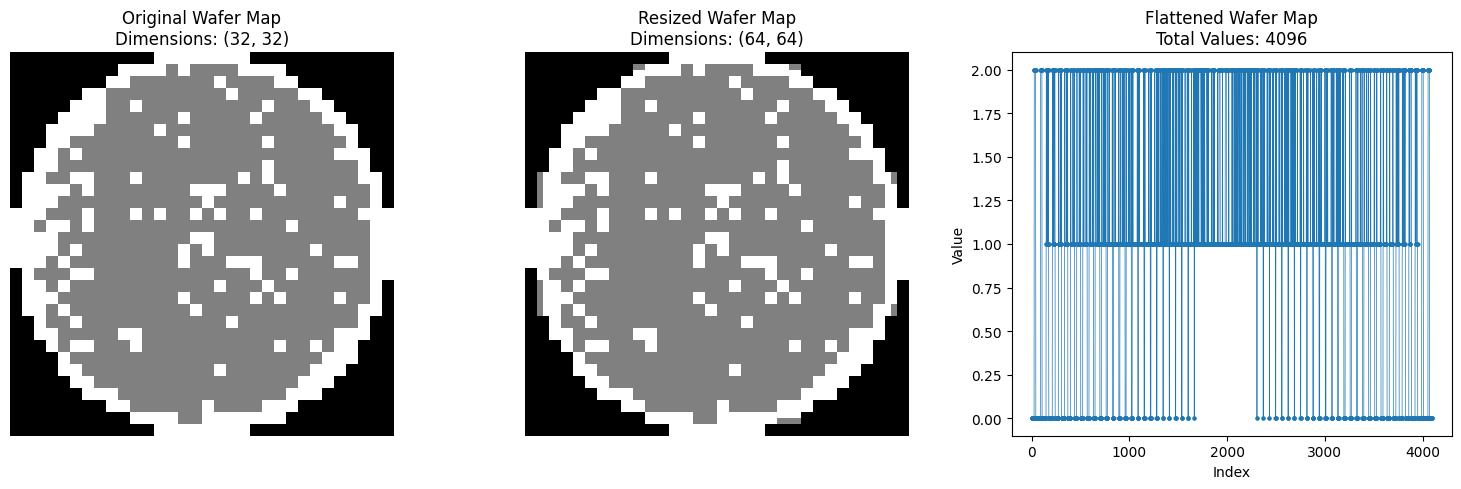

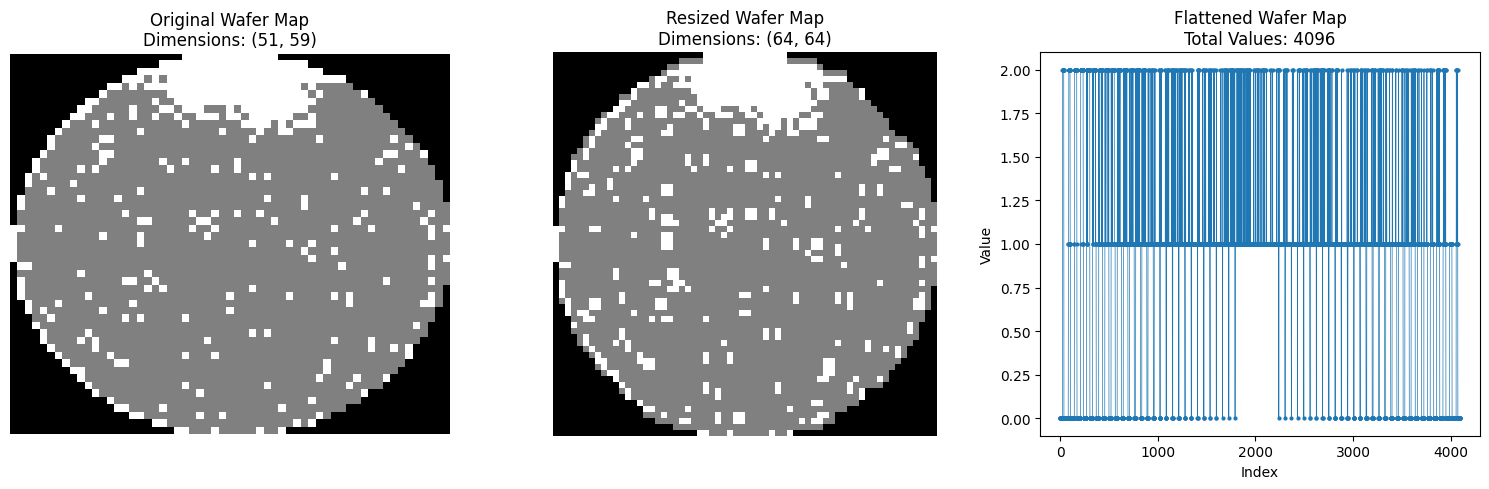

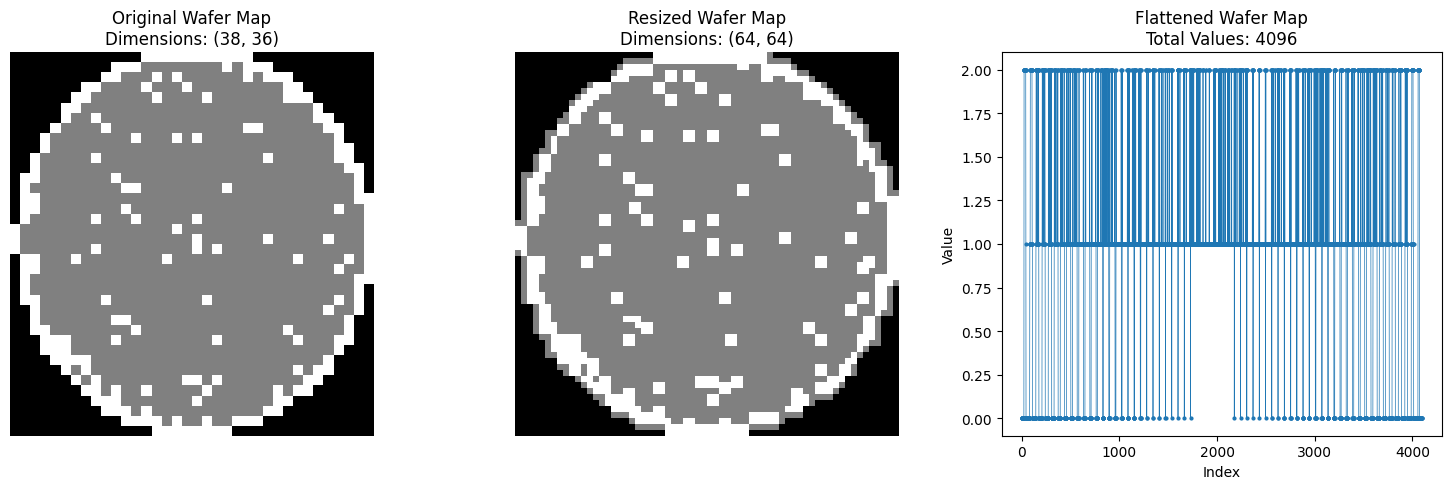

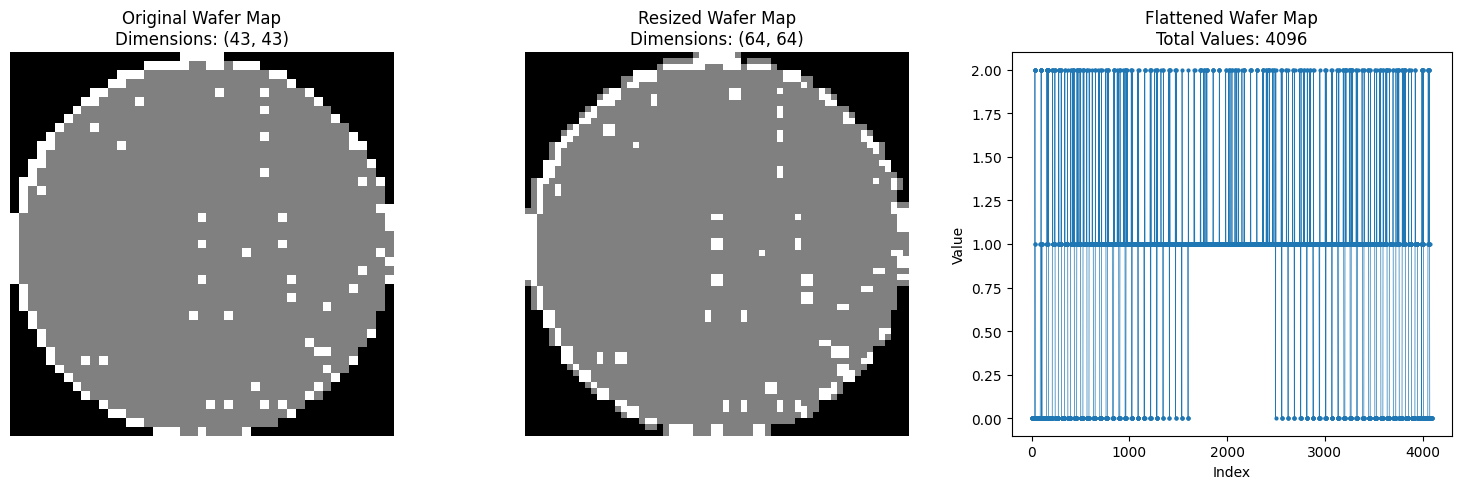

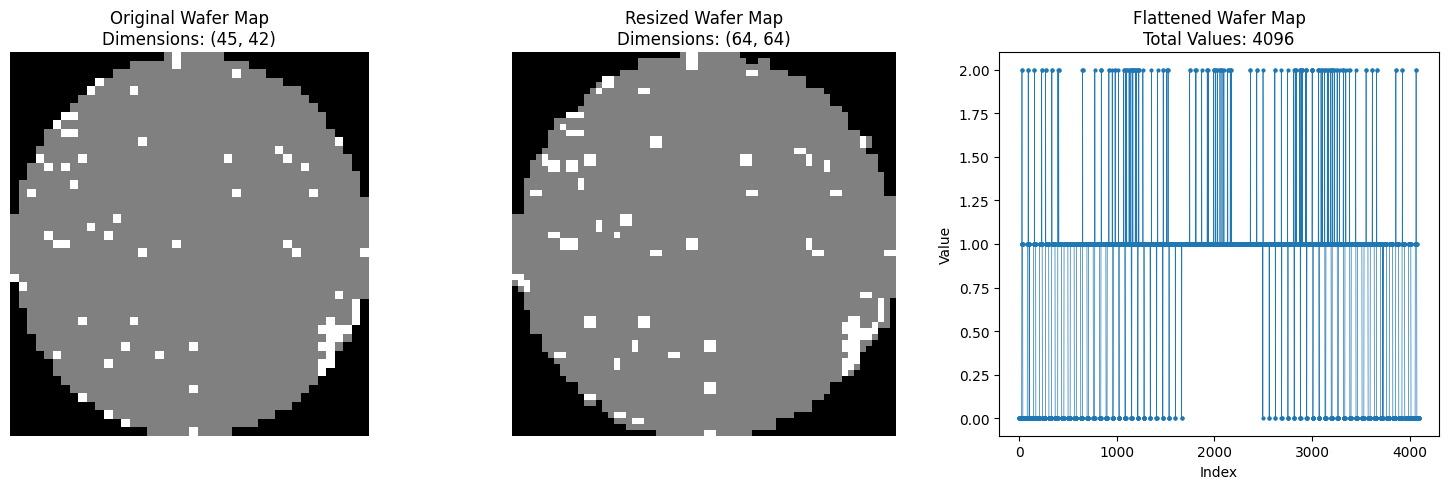

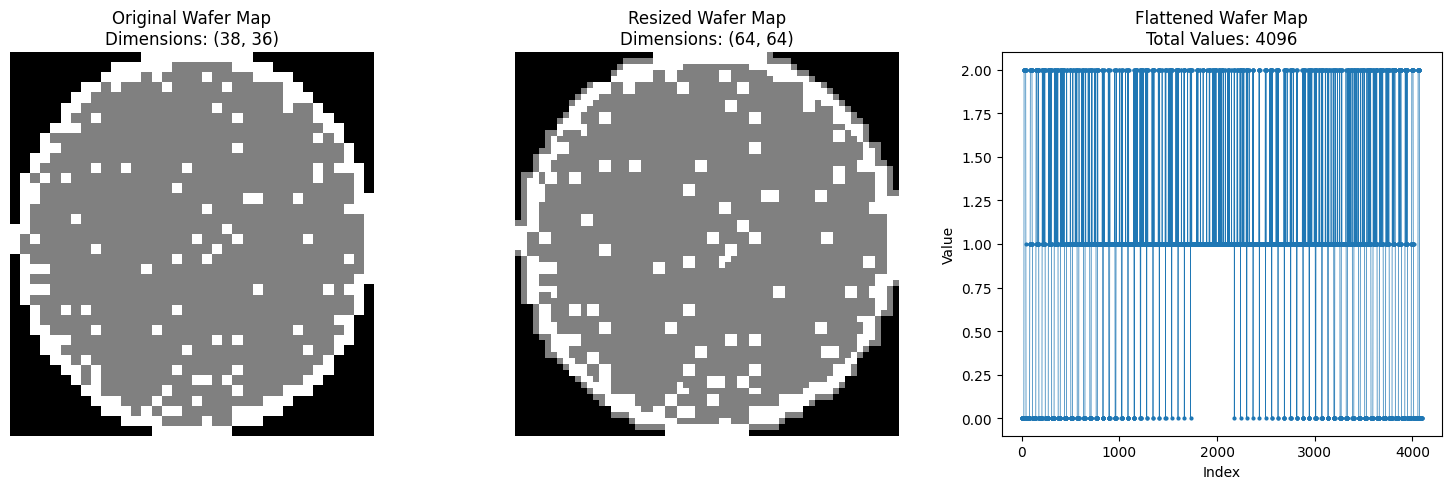

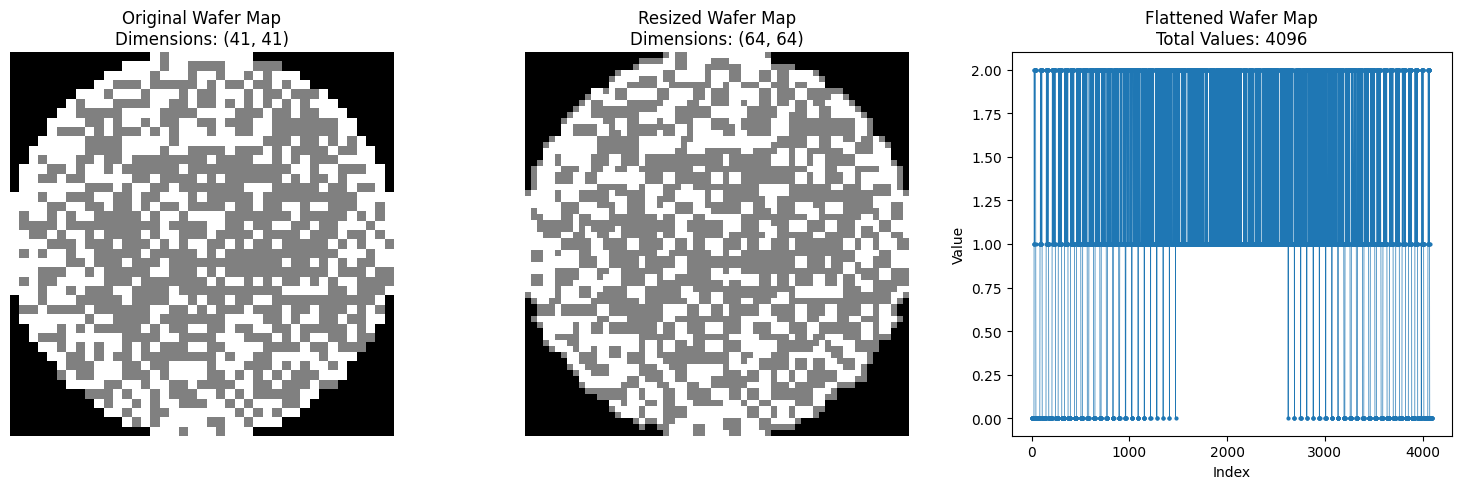

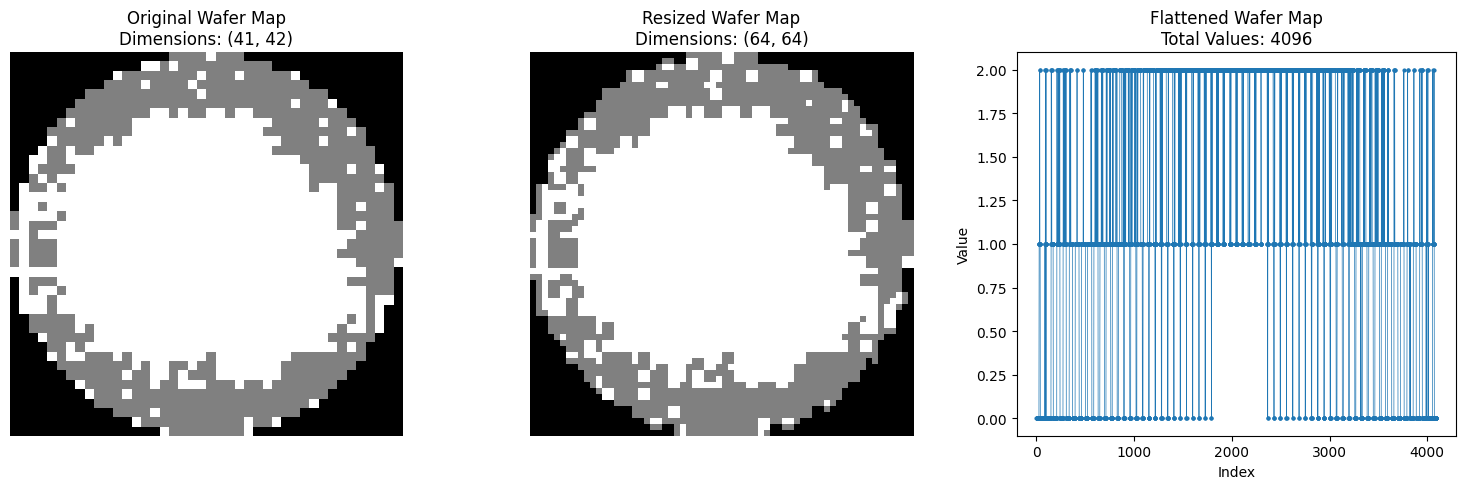

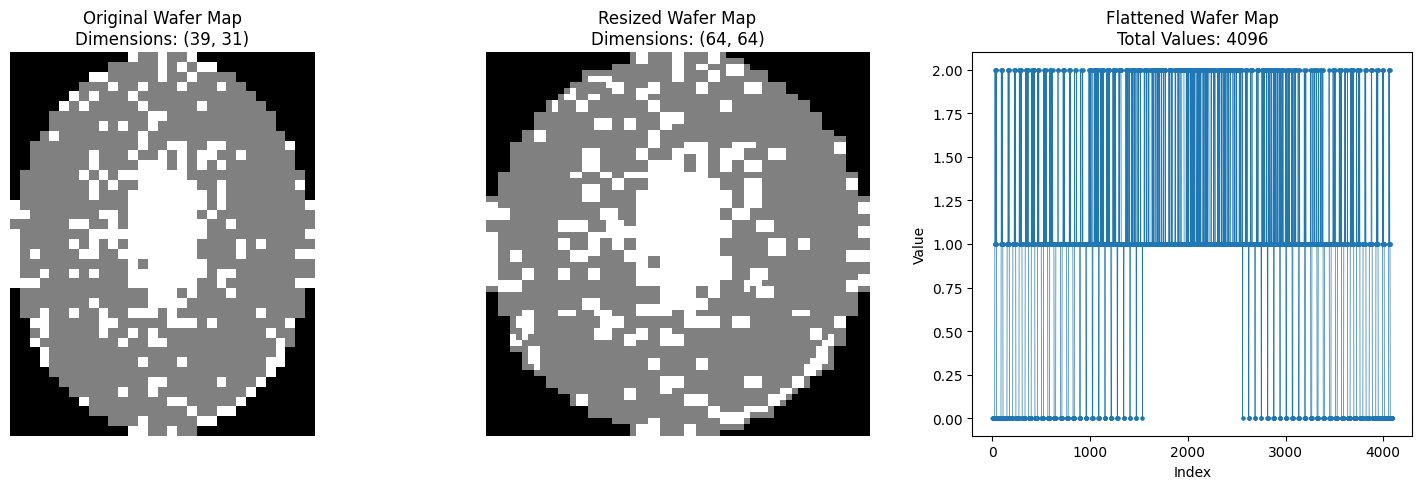

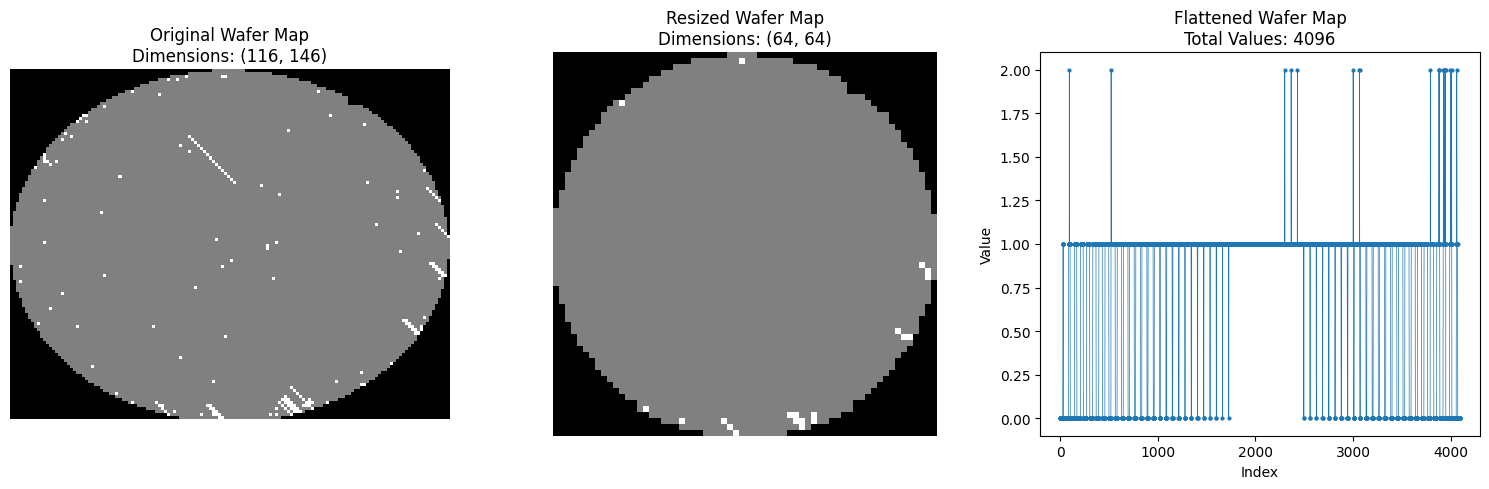

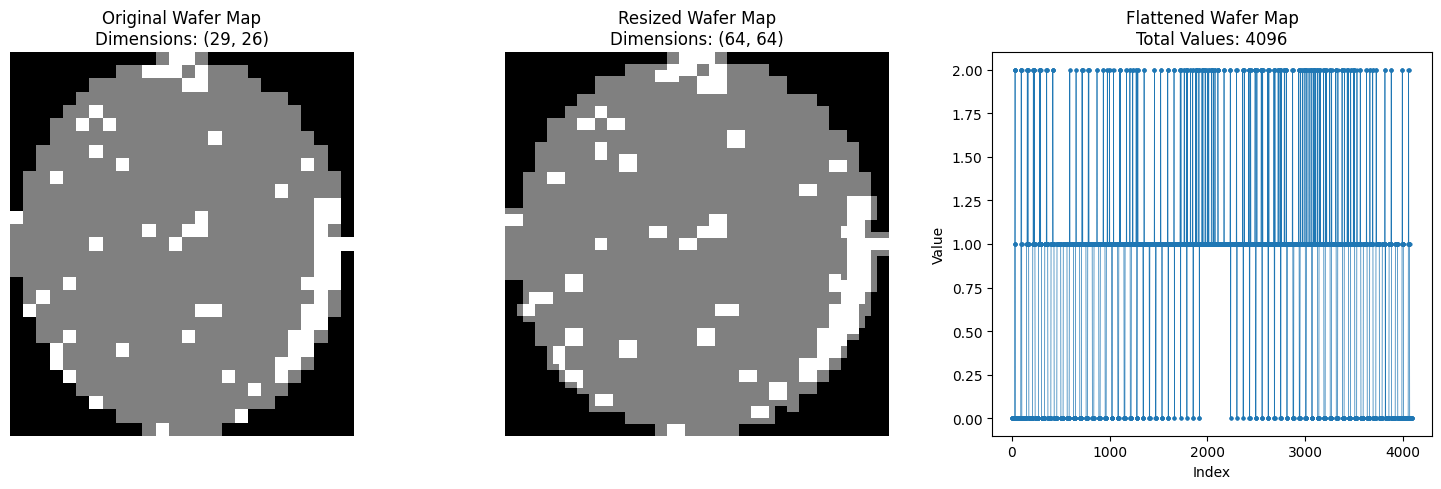

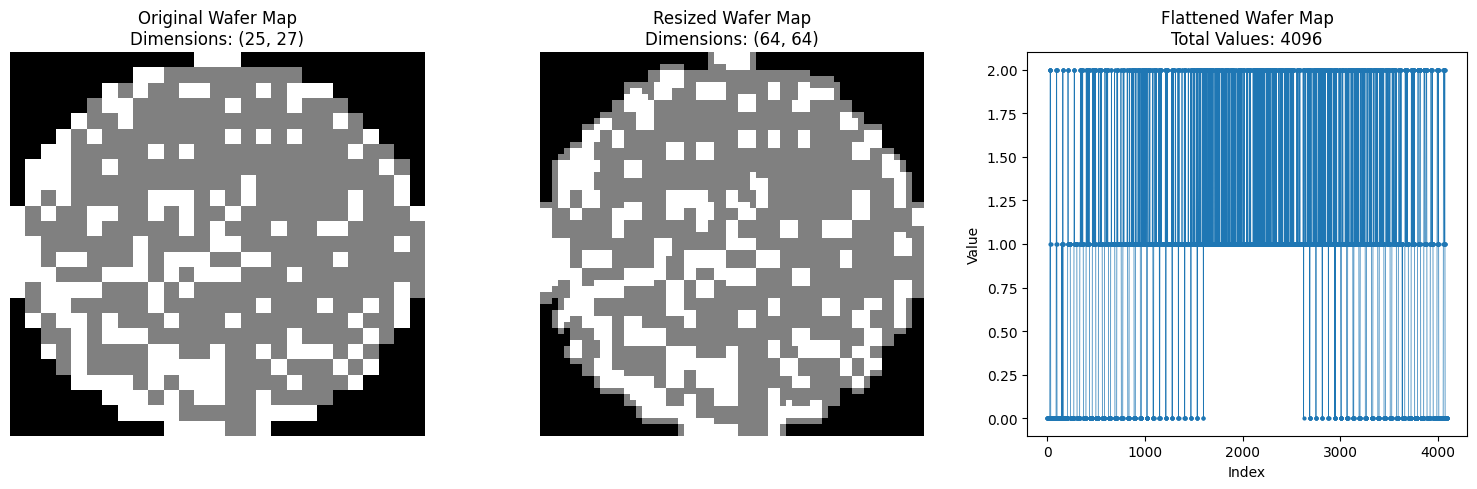

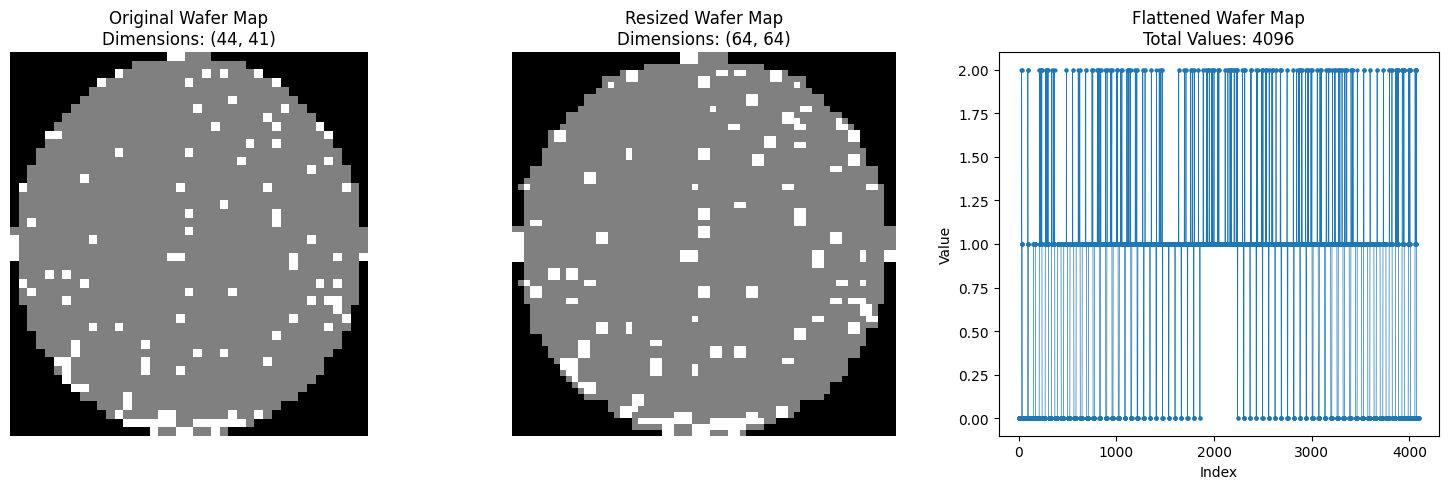

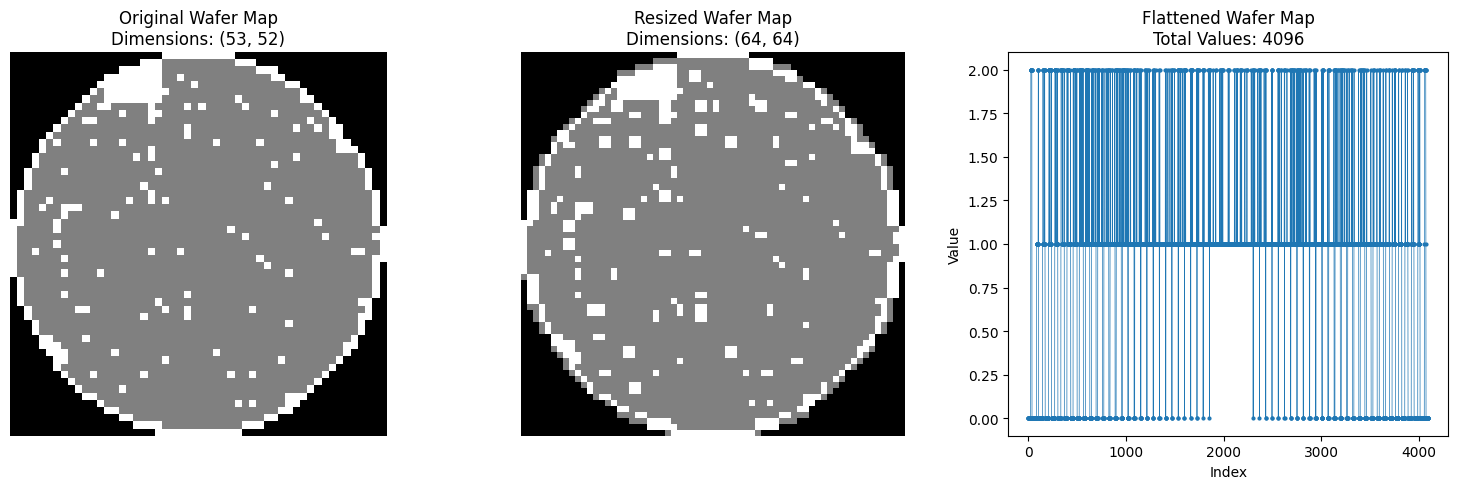

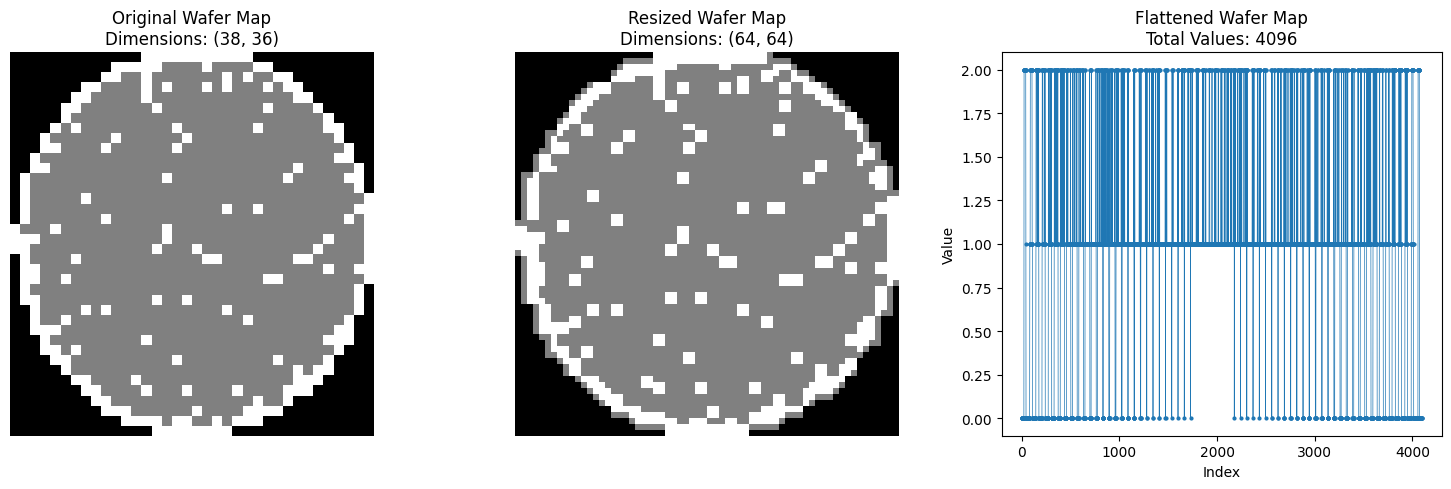

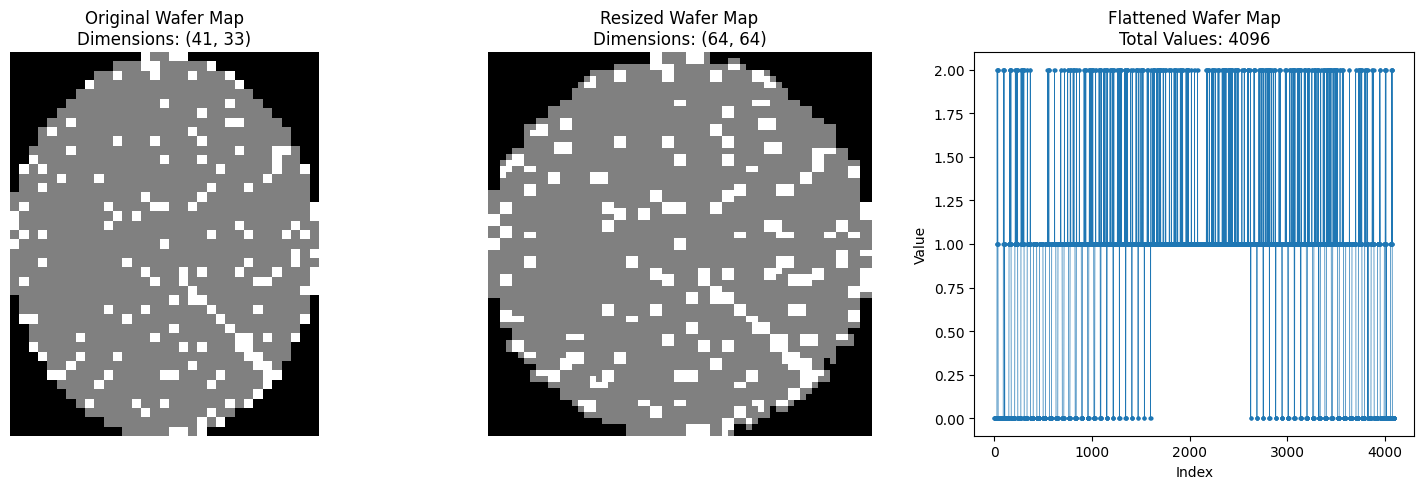

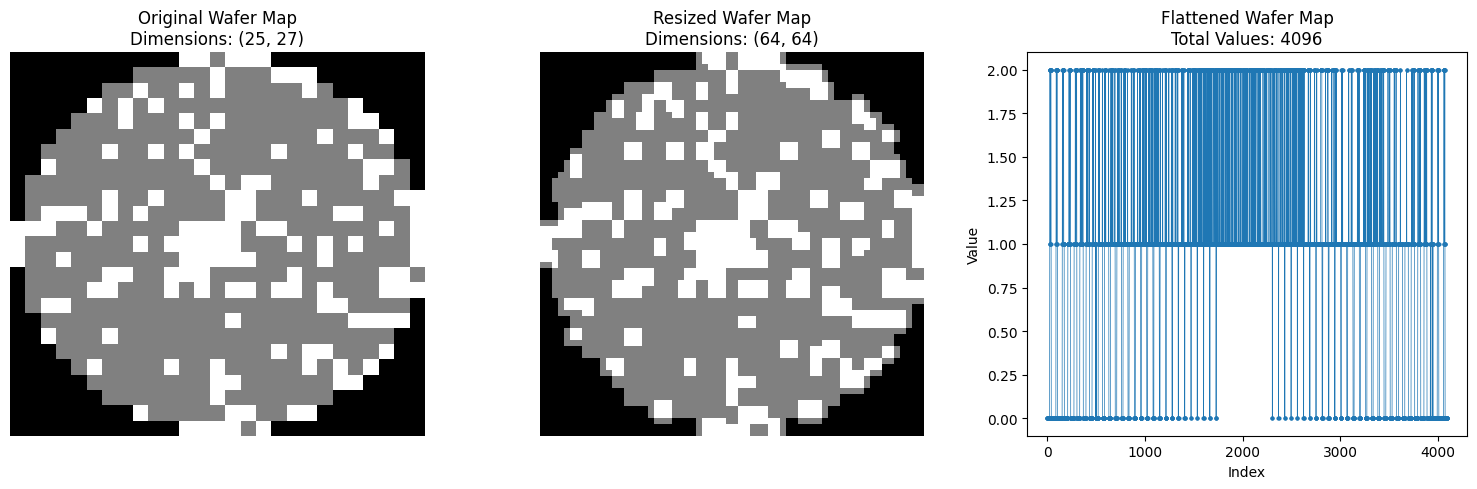

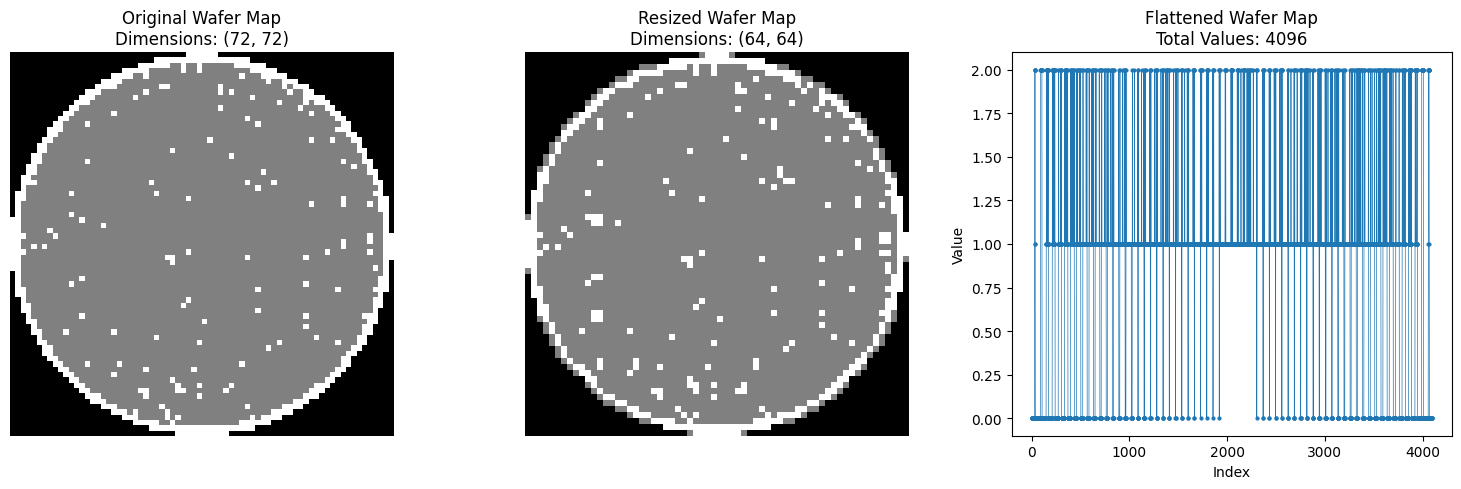

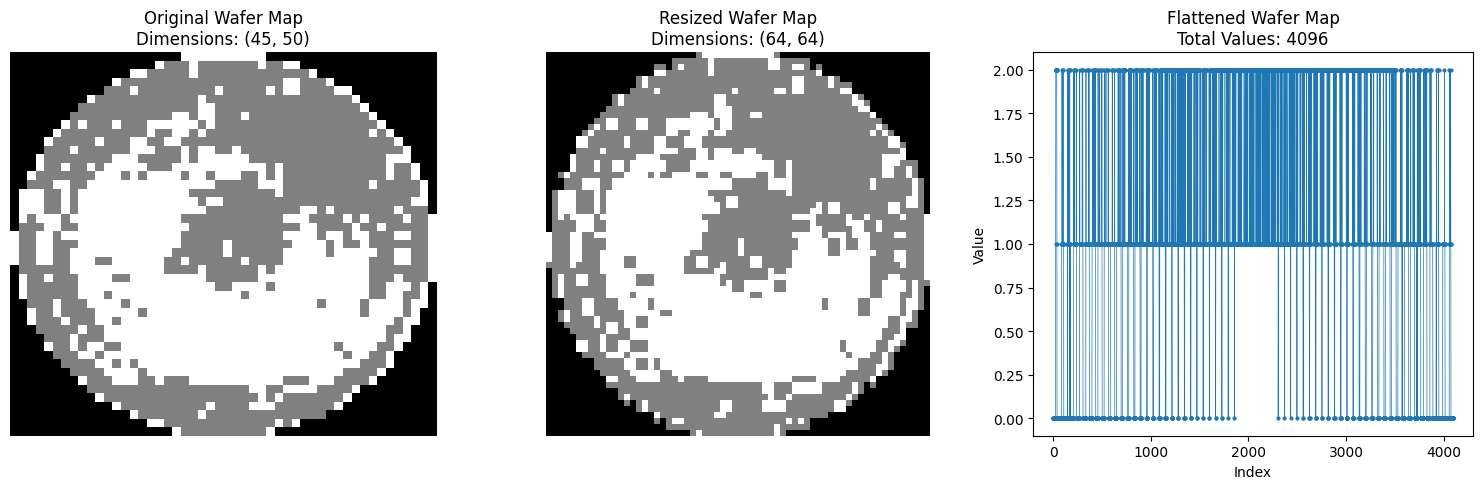

In [8]:
def plot_wafer_maps(original, resized, flattened):
    # Get dimensions of the images
    original_dim = original.shape
    resized_dim = resized.shape

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original wafer map
    axs[0].imshow(original, cmap='gray')  # Assuming the wafer map is grayscale
    axs[0].set_title(f"Original Wafer Map\nDimensions: {original_dim}")
    axs[0].axis('off')  # Turn off axis

    # Plot the resized wafer map
    axs[1].imshow(resized, cmap='gray')  # Assuming the resized image is also grayscale
    axs[1].set_title(f"Resized Wafer Map\nDimensions: {resized_dim}")
    axs[1].axis('off')

    # Plot the flattened wafer map as a 1D array (visualizing as a bar plot)
    axs[2].plot(flattened, marker='o', markersize=2, linestyle='-', linewidth=0.5)
    axs[2].set_title(f"Flattened Wafer Map\nTotal Values: {len(flattened)}")
    axs[2].set_xlabel("Index")
    axs[2].set_ylabel("Value")

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()

# Randomly select 20 samples from the DataFrame
random_indices = random.sample(range(len(df_modified_labelled)), 20)

# Loop through and plot each sample
for idx in random_indices:
    original_map = df_modified_labelled.loc[idx, 'waferMap']
    resized_map = df_modified_labelled.loc[idx, 'waferMap_resized']
    flattened_map = df_modified_labelled.loc[idx, 'waferMap_flat']

    # Call the function to plot
    plot_wafer_maps(original_map, resized_map, flattened_map)


In [9]:
# Reset index to ensure alignment
df_modified_labelled.reset_index(drop=True, inplace=True)
df_modified_labelled['original_index'] = df_modified_labelled.index

# Prepare data for oversampling
X = np.stack(df_modified_labelled['waferMap_flat'].values).astype('float32')
y = df_modified_labelled['failureType']
original_indices = df_modified_labelled['original_index'].values

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Get sample indices from oversampling
sample_indices = ros.sample_indices_

# Map back to original indices
resampled_original_indices = original_indices[sample_indices]

# Encode labels
encoder = LabelEncoder()
y_resampled_enc = encoder.fit_transform(y_resampled)
num_classes = len(encoder.classes_)

# Create a DataFrame with resampled data
df_resampled = pd.DataFrame({
    'waferMap_flat': list(X_resampled),
    'failureType_enc': y_resampled_enc,
    'original_index': resampled_original_indices
})

# Split the data and indices
df_train, df_test = train_test_split(
    df_resampled,
    test_size=0.2,
    random_state=42,
    stratify=df_resampled['failureType_enc']
)

In [10]:
df_train, df_test = train_test_split(
    df_resampled, test_size=0.2, random_state=42, stratify=df_resampled['failureType_enc'])

In [11]:
# Prepare training data
X_train_full = np.stack(df_train['waferMap_flat'].values).astype('float32')
y_train_full_enc = df_train['failureType_enc'].values

# Prepare test data
X_test = np.stack(df_test['waferMap_flat'].values).astype('float32')
y_test_enc = df_test['failureType_enc'].values

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train_full_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_full_enc, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, num_classes):
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))      
        x = self.fc4(x)
        return x

In [ ]:
# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
model = SimpleNN(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

model.eval()
with torch.no_grad():
    y_pred_list = []
    y_true_list = []

    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_list.extend(predicted.numpy())
        y_true_list.extend(labels.numpy())


Epoch [1/10], Loss: 0.3462, Accuracy: 86.83%
Epoch [2/10], Loss: 0.1196, Accuracy: 95.93%
Epoch [3/10], Loss: 0.0644, Accuracy: 97.84%
Epoch [4/10], Loss: 0.0386, Accuracy: 98.69%
Epoch [5/10], Loss: 0.0364, Accuracy: 98.86%
Epoch [6/10], Loss: 0.0252, Accuracy: 99.18%
Epoch [7/10], Loss: 0.0272, Accuracy: 99.13%
Epoch [8/10], Loss: 0.0198, Accuracy: 99.38%
Epoch [9/10], Loss: 0.0208, Accuracy: 99.40%
Epoch [10/10], Loss: 0.0153, Accuracy: 99.50%


In [21]:
from sklearn.metrics import accuracy_score

# Calculate test accuracy
test_accuracy = accuracy_score(y_true_list, y_pred_list)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 97.24%


Classification Report:


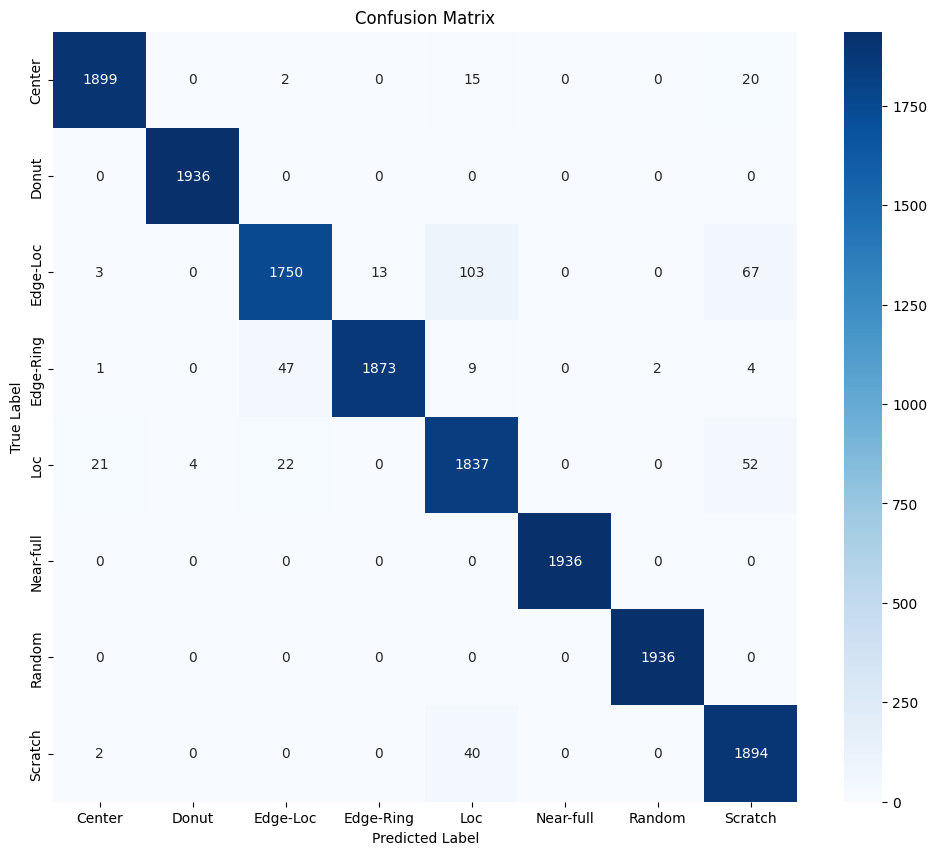

In [22]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)

# Print classification report
print("Classification Report:")

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Retrieve the original indices of the test set samples
test_original_indices = df_test['original_index'].values

# Retrieve the wafer maps for the test set
test_wafer_maps = df_modified_labelled['waferMap_resized'].iloc[test_original_indices].values

# Map encoded labels back to original labels
label_mapping = {index: label for index, label in enumerate(encoder.classes_)}

# Ensure the lengths match
assert len(test_wafer_maps) == len(y_true_list), "Mismatch in test samples and predictions"

# Set the number of samples to plot
num_samples_to_plot = 20

# Generate random indices
random_indices = random.sample(range(len(test_wafer_maps)), num_samples_to_plot)

for idx in random_indices:
    wafer_map = test_wafer_maps[idx]
    true_label = label_mapping[y_true_list[idx]]
    pred_label = label_mapping[y_pred_list[idx]]
    
    plt.figure(figsize=(4, 4))
    plt.imshow(wafer_map, cmap='gray')
    plt.title(f"True Label: {true_label}\nPredicted Label: {pred_label}")
    plt.axis('off')
    plt.show()

Total misclassified samples: 427
Number of misclassified images to plot: 30


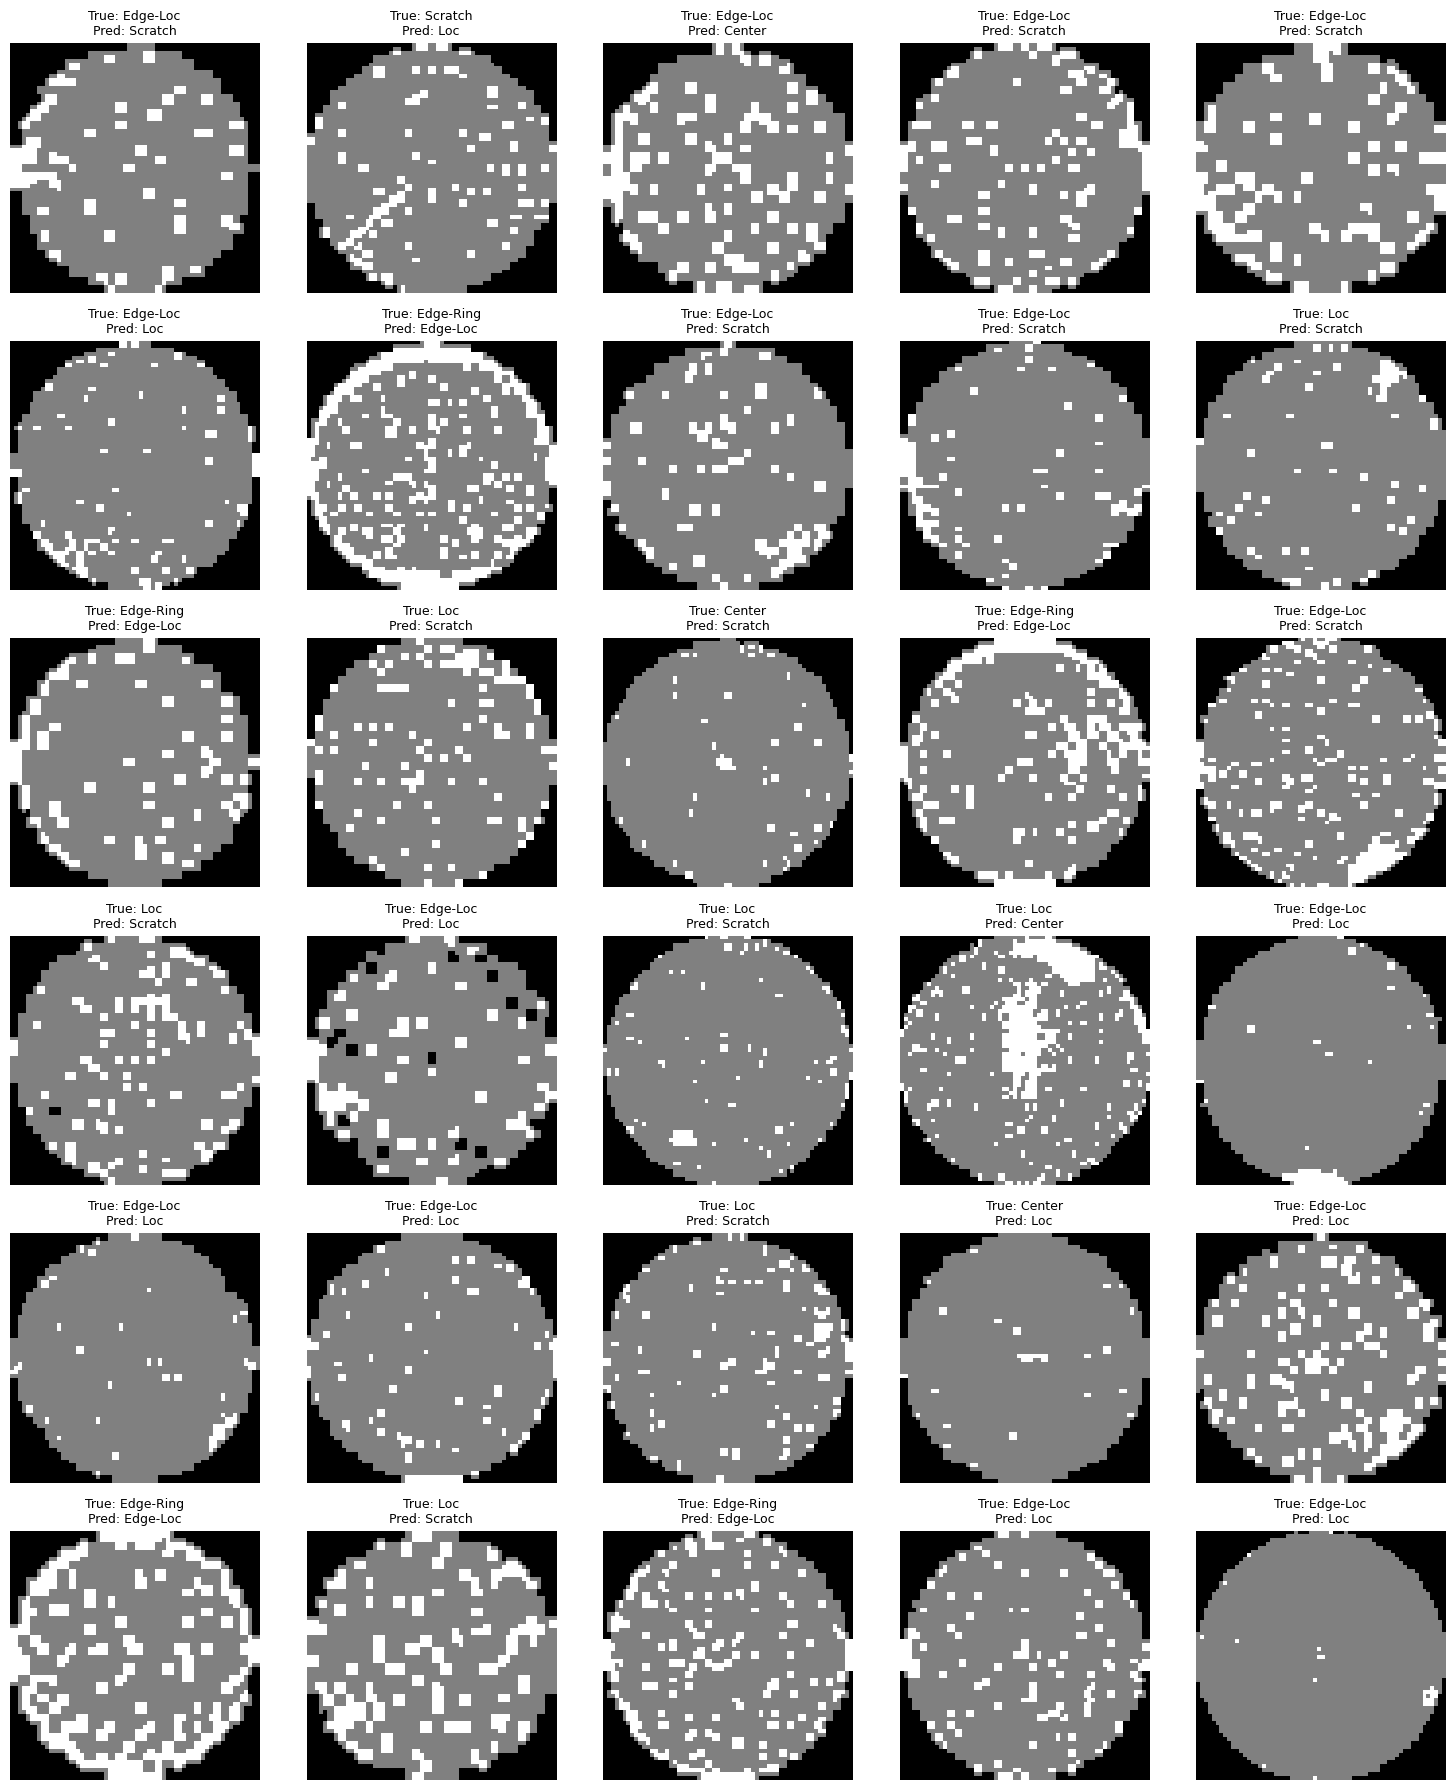

In [ ]:
# Convert lists to numpy arrays
y_true_array = np.array(y_true_list)
y_pred_array = np.array(y_pred_list)

# Find indices where predictions are incorrect
misclassified_indices = np.where(y_true_array != y_pred_array)[0]

# Total number of misclassified samples
num_misclassified = len(misclassified_indices)
print(f"Total misclassified samples: {num_misclassified}")

# Desired number of images per row and number of rows
images_per_row = 5
num_rows = 6
max_images_to_plot = images_per_row * num_rows

# Adjust the number of images to plot if there are fewer misclassifications
num_images_to_plot = min(num_misclassified, max_images_to_plot)
print(f"Number of misclassified images to plot: {num_images_to_plot}")

import random

# Randomly select misclassified indices to plot
if num_misclassified > num_images_to_plot:
    selected_indices = random.sample(list(misclassified_indices), num_images_to_plot)
else:
    selected_indices = misclassified_indices

# Retrieve wafer maps for the selected misclassified samples
wafer_maps_misclassified = test_wafer_maps[selected_indices]

# Retrieve true and predicted labels
true_labels_misclassified = y_true_array[selected_indices]
pred_labels_misclassified = y_pred_array[selected_indices]

# Create label mapping dictionary
label_mapping = {index: label for index, label in enumerate(encoder.classes_)}

# Convert numerical labels to string labels
true_labels_str = [label_mapping[label] for label in true_labels_misclassified]
pred_labels_str = [label_mapping[label] for label in pred_labels_misclassified]

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each misclassified wafer map
for idx, ax in enumerate(axes):
    if idx < num_images_to_plot:
        wafer_map = wafer_maps_misclassified[idx]
        true_label = true_labels_str[idx]
        pred_label = pred_labels_str[idx]
        
        ax.imshow(wafer_map, cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
        ax.axis('off')
    else:
        # Hide any unused subplots
        ax.axis('off')

plt.tight_layout()
plt.show()